## Data Prep

In [1]:
import warnings
warnings.filterwarnings("ignore")
import joblib
import gc
import multiprocessing as mp
import numpy as np
import pandas as pd
import _pickle as cpickle
import seaborn as sns
import pickle
import lightgbm as lgb
from lightgbm.sklearn import LGBMClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, f1_score,roc_curve
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

In [2]:
# Importing each csv files
orders = pd.read_csv("/Users/data/Desktop/instacart-market-basket-analysis/csvs/orders.csv")
order_products_train = pd.read_csv("/Users/data/Desktop/instacart-market-basket-analysis/csvs/order_products__train.csv")

In [3]:
# Importing features 
users_df =  pd.read_pickle("/Users/data/Desktop/Features@Library/Features/users_df.pkl")
products_df =  pd.read_pickle("/Users/data/Desktop/Features@Library/Features/products_df.pkl")
user_x_product =  pd.read_pickle("/Users/data/Desktop/Features@Library/Features/uxp_df.pkl")

In [4]:
# Merging user_x_product features with users features
data = user_x_product.merge(users_df, on='user_id', how='left')
data.head()


,user_id,product_id,times_brought,uxp_total_reordered,uxp_first_order_num,uxp_avg_cart_pos,uxp_min_cart_pos,uxp_max_cart_pos,uxp_median_cart_pos,uxp_last_order_num,...,reordered_ratio,total_num_orders,user_total_prods,user_unique_prods,user_average_basket,user_order_starts_at,avg_no_prds_each_purchase,median_no_prds_each_purchase,min_no_prds_each_purchase,max_no_prds_each_purchase
0,1,196,10,9,1,1.400000,1,4,1.0,10,...,0.694915,343,59,18,0.172012,431534,5.9,5.5,4,9
1,1,10258,9,8,2,3.333333,2,6,3.0,10,...,0.694915,343,59,18,0.172012,431534,5.9,5.5,4,9
2,1,10326,1,0,5,5.000000,5,5,5.0,5,...,0.694915,343,59,18,0.172012,431534,5.9,5.5,4,9
3,1,12427,10,9,1,3.300000,1,9,2.5,10,...,0.694915,343,59,18,0.172012,431534,5.9,5.5,4,9
4,1,13032,3,2,2,6.333333,5,8,6.0,10,...,0.694915,343,59,18,0.172012,431534,5.9,5.5,4,9


In [5]:
# Merging product features with data.
data = data.merge(products_df, on='product_id', how='left')
data.head()

,user_id,product_id,times_brought,uxp_total_reordered,uxp_first_order_num,uxp_avg_cart_pos,uxp_min_cart_pos,uxp_max_cart_pos,uxp_median_cart_pos,uxp_last_order_num,...,prod_tot_reorders,prod_reordered_ratio,avg_cart_position,median_cart_position,sum_cart_position,min_cart_position,max_cart_position,std_cart_position,aisle_reorder_ratio,department_reorder_ratio
0,1,196,10,9,1,1.400000,1,4,1.0,10,...,27791,0.776480,3.721774,2.0,133206,1,60,4.110813,0.638832,0.653460
1,1,10258,9,8,2,3.333333,2,6,3.0,10,...,1389,0.713772,4.277492,3.0,8324,1,29,3.567502,0.519170,0.574180
2,1,10326,1,0,5,5.000000,5,5,5.0,5,...,3603,0.652009,4.191097,3.0,23160,1,37,3.611700,0.718104,0.649913
3,1,12427,10,9,1,3.300000,1,9,2.5,10,...,4797,0.740735,4.760037,3.0,30826,1,61,4.782450,0.591986,0.574180
4,1,13032,3,2,2,6.333333,5,8,6.0,10,...,2465,0.657158,5.622767,4.0,21091,1,66,5.345184,0.571584,0.560922


In [6]:
data.shape

(13307953, 48)

In [7]:
# Let's first get the future orders.(train and test eval_set)
future_orders = orders[((orders['eval_set'] == 'train') | (orders['eval_set'] == 'test'))]
future_orders.head()


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
10,1187899,1,train,11,4,8,14.0
25,1492625,2,train,15,1,11,30.0
38,2774568,3,test,13,5,15,11.0
44,329954,4,test,6,3,12,30.0
49,2196797,5,train,5,0,11,6.0


In [8]:
future_orders = future_orders[['user_id','order_id','eval_set']]
future_orders.head()


,user_id,order_id,eval_set
10,1,1187899,train
25,2,1492625,train
38,3,2774568,test
44,4,329954,test
49,5,2196797,train


In [9]:
# Merging data with future orders
data = data.merge(future_orders,on='user_id',how='left')
data.head()


,user_id,product_id,times_brought,uxp_total_reordered,uxp_first_order_num,uxp_avg_cart_pos,uxp_min_cart_pos,uxp_max_cart_pos,uxp_median_cart_pos,uxp_last_order_num,...,avg_cart_position,median_cart_position,sum_cart_position,min_cart_position,max_cart_position,std_cart_position,aisle_reorder_ratio,department_reorder_ratio,order_id,eval_set
0,1,196,10,9,1,1.400000,1,4,1.0,10,...,3.721774,2.0,133206,1,60,4.110813,0.638832,0.653460,1187899,train
1,1,10258,9,8,2,3.333333,2,6,3.0,10,...,4.277492,3.0,8324,1,29,3.567502,0.519170,0.574180,1187899,train
2,1,10326,1,0,5,5.000000,5,5,5.0,5,...,4.191097,3.0,23160,1,37,3.611700,0.718104,0.649913,1187899,train
3,1,12427,10,9,1,3.300000,1,9,2.5,10,...,4.760037,3.0,30826,1,61,4.782450,0.591986,0.574180,1187899,train
4,1,13032,3,2,2,6.333333,5,8,6.0,10,...,5.622767,4.0,21091,1,66,5.345184,0.571584,0.560922,1187899,train


In [10]:
# Getting only the training data set
data_train = data[data['eval_set'] == 'train']
data_train.head()


,user_id,product_id,times_brought,uxp_total_reordered,uxp_first_order_num,uxp_avg_cart_pos,uxp_min_cart_pos,uxp_max_cart_pos,uxp_median_cart_pos,uxp_last_order_num,...,avg_cart_position,median_cart_position,sum_cart_position,min_cart_position,max_cart_position,std_cart_position,aisle_reorder_ratio,department_reorder_ratio,order_id,eval_set
0,1,196,10,9,1,1.400000,1,4,1.0,10,...,3.721774,2.0,133206,1,60,4.110813,0.638832,0.653460,1187899,train
1,1,10258,9,8,2,3.333333,2,6,3.0,10,...,4.277492,3.0,8324,1,29,3.567502,0.519170,0.574180,1187899,train
2,1,10326,1,0,5,5.000000,5,5,5.0,5,...,4.191097,3.0,23160,1,37,3.611700,0.718104,0.649913,1187899,train
3,1,12427,10,9,1,3.300000,1,9,2.5,10,...,4.760037,3.0,30826,1,61,4.782450,0.591986,0.574180,1187899,train
4,1,13032,3,2,2,6.333333,5,8,6.0,10,...,5.622767,4.0,21091,1,66,5.345184,0.571584,0.560922,1187899,train


In [14]:
# Merging the information contained in order_products_train csv with data_train
data_train = data_train.merge(order_products_train[['product_id','order_id','reordered']],on=['product_id','order_id'],how='left')
data_train.head()


,user_id,product_id,times_brought,uxp_total_reordered,uxp_first_order_num,uxp_avg_cart_pos,uxp_min_cart_pos,uxp_max_cart_pos,uxp_median_cart_pos,uxp_last_order_num,...,median_cart_position,sum_cart_position,min_cart_position,max_cart_position,std_cart_position,aisle_reorder_ratio,department_reorder_ratio,order_id,eval_set,reordered
0,1,196,10,9,1,1.400000,1,4,1.0,10,...,2.0,133206,1,60,4.110813,0.638832,0.653460,1187899,train,1.0
1,1,10258,9,8,2,3.333333,2,6,3.0,10,...,3.0,8324,1,29,3.567502,0.519170,0.574180,1187899,train,1.0
2,1,10326,1,0,5,5.000000,5,5,5.0,5,...,3.0,23160,1,37,3.611700,0.718104,0.649913,1187899,train,NaN
3,1,12427,10,9,1,3.300000,1,9,2.5,10,...,3.0,30826,1,61,4.782450,0.591986,0.574180,1187899,train,NaN
4,1,13032,3,2,2,6.333333,5,8,6.0,10,...,4.0,21091,1,66,5.345184,0.571584,0.560922,1187899,train,1.0


In [15]:
# replace Nan with 0 in data_train
data_train['reordered'].fillna(0,inplace=True)

In [16]:
# Setting the index for train data as a combination of user-id and product-id
data_train = data_train.set_index(['user_id','product_id'])

# Dropping the eval_set and order_id columns
data_train.drop(['eval_set','order_id'],axis=1,inplace=True)

#display
data_train.head()


times_brought  uxp_total_reordered  uxp_first_order_num  \
user_id product_id                                                            
1       196                    10                    9                    1   
        10258                   9                    8                    2   
        10326                   1                    0                    5   
        12427                  10                    9                    1   
        13032                   3                    2                    2   

                    uxp_avg_cart_pos  uxp_min_cart_pos  uxp_max_cart_pos  \
user_id product_id                                                         
1       196                 1.400000                 1                 4   
        10258               3.333333                 2                 6   
        10326               5.000000                 5                 5   
        12427               3.300000                 1                 9   
        13032               6.333333                 5                 8   

                    uxp_median_cart_pos  uxp_last_order_num  uxp_avg_dow  \
user_id product_id                                                         
1       196                         1.0                  10     2.500000   
        10258                       3.0                  10     2.555556   
        10326                       5.0                   5     4.000000   
        12427                       2.5                  10     2.500000   
        13032                       6.0                  10     2.666667   

                    uxp_median_dow  ...  prod_reordered_ratio  \
user_id product_id                  ...                         
1       196                    2.5  ...              0.776480   
        10258                  3.0  ...              0.713772   
        10326                  4.0  ...              0.652009   
        12427                  2.5  ...              0.740735   
        13032                  3.0  ...              0.657158   

                    avg_cart_position  median_cart_position  \
user_id product_id                                            
1       196                  3.721774                   2.0   
        10258                4.277492                   3.0   
        10326                4.191097                   3.0   
        12427                4.760037                   3.0   
        13032                5.622767                   4.0   

                    sum_cart_position  min_cart_position  max_cart_position  \
user_id product_id                                                            
1       196                    133206                  1                 60   
        10258                    8324                  1                 29   
        10326                   23160                  1                 37   
        12427                   30826                  1                 61   
        13032                   21091                  1                 66   

                    std_cart_position  aisle_reorder_ratio  \
user_id product_id                                           
1       196                  4.110813             0.638832   
        10258                3.567502             0.519170   
        10326                3.611700             0.718104   
        12427                4.782450             0.591986   
        13032                5.345184             0.571584   

                    department_reorder_ratio  reordered  
user_id product_id                                       
1       196                         0.653460        1.0  
        10258                       0.574180        1.0  
        10326                       0.649913        0.0  
        12427                       0.574180        0.0  
        13032                       0.560922        1.0  

[5 rows x 47 columns]

In [17]:
# following same steps as above for test data

data_test = data[data['eval_set'] == 'test']
data_test.head()

# Setting the index for train data as a combination of user-id and product-id
data_test = data_test.set_index(['user_id','product_id'])

# Dropping the eval_set and order_id columns
data_test.drop(['eval_set','order_id'],axis=1,inplace=True)

#display
data_test.head()


times_brought  uxp_total_reordered  uxp_first_order_num  \
user_id product_id                                                            
3       248                     1                    0                    2   
        1005                    1                    0                   10   
        1819                    3                    2                    4   
        7503                    1                    0                    3   
        8021                    1                    0                    2   

                    uxp_avg_cart_pos  uxp_min_cart_pos  uxp_max_cart_pos  \
user_id product_id                                                         
3       248                 3.000000                 3                 3   
        1005                5.000000                 5                 5   
        1819                2.666667                 1                 5   
        7503                6.000000                 6                 6   
        8021                5.000000                 5                 5   

                    uxp_median_cart_pos  uxp_last_order_num  uxp_avg_dow  \
user_id product_id                                                         
3       248                         3.0                   2     3.000000   
        1005                        5.0                  10     3.000000   
        1819                        2.0                   7     0.666667   
        7503                        6.0                   3     3.000000   
        8021                        5.0                   2     3.000000   

                    uxp_median_dow  ...  prod_tot_reorders  \
user_id product_id                  ...                      
3       248                    3.0  ...               2550   
        1005                   3.0  ...                204   
        1819                   0.0  ...               1193   
        7503                   3.0  ...               6905   
        8021                   3.0  ...              16472   

                    prod_reordered_ratio  avg_cart_position  \
user_id product_id                                            
3       248                     0.400251          10.620782   
        1005                    0.440605           9.498920   
        1819                    0.492162           9.287541   
        7503                    0.553551           9.547379   
        8021                    0.591157           8.822854   

                    median_cart_position  sum_cart_position  \
user_id product_id                                            
3       248                          9.0              67665   
        1005                         8.0               4398   
        1819                         7.0              22513   
        7503                         8.0             119094   
        8021                         7.0             245840   

                    min_cart_position  max_cart_position  std_cart_position  \
user_id product_id                                                            
3       248                         1                 91           8.025390   
        1005                        1                 74           7.984800   
        1819                        1                 68           7.441465   
        7503                        1                 79           7.622521   
        8021                        1                 90           7.211007   

                    aisle_reorder_ratio  department_reorder_ratio  
user_id product_id                                                 
3       248                    0.519170                  0.574180  
        1005                   0.527615                  0.653460  
        1819                   0.487633                  0.346721  
        7503                   0.519170                  0.574180  
        8021                   0.528005                  0.402178  

[5 rows x 46 columns]

In [18]:
print("Train data shape - ",data_train.shape)
print("Test data shape - ",data_test.shape)


Train data shape -  (8474661, 47)
Test data shape -  (4833292, 46)


In [19]:
# Deleting unwanted data frames
del [data,future_orders,orders]


In [20]:
from sklearn.model_selection import train_test_split
from downcast import reduce

# replace Nan values with mean values
data_train.fillna(data_train.mean(), inplace=True)
data_train = reduce(data_train)

# Creating X and y(target variable)
X = data_train.drop(['reordered','min_number_of_orders'], axis=1)
y = data_train['reordered']

#replace Nan values with mean values
#X.fillna(X.mean(), inplace=True)


In [21]:
#splitting dataset into train and test split.
X.fillna(X.mean(), inplace=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10,stratify=y)


In [22]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(5932262, 45)
(5932262,)
(2542399, 45)
(2542399,)


In [23]:
# Taken from Facebook Recomendation system case study

def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()


### Veri Setini %80 oranında küçült

In [24]:
from sklearn.model_selection import train_test_split

# X_train ve y_train veri setlerinizi yükleyin
# X_train = ...
# y_train = ...

# Stratified sampling uygulayarak veri setini %20'ye düşürün
X_train_strat, X_discard, y_train_strat, y_discard = train_test_split(
    X_train, y_train, test_size=0.8, stratify=y_train, random_state=42)

# Sonuçların boyutlarını kontrol etme
print(X_train_strat.shape)
print(y_train_strat.shape)

(1186452, 45)
(1186452,)


In [25]:
X_train = X_train_strat
y_train = y_train_strat

In [26]:
y_train.value_counts()

reordered
0.0    1070417
1.0     116035
Name: count, dtype: int64

# Light Gbm

In [26]:
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV
param_grid = {
'num_leaves': list(range(8, 92, 4)),
'max_depth': [3, 4, 5, 6, 8, 10,12],
'learning_rate': [0.1, 0.05, 0.01, 0.005],
}

lgb_model=lgb.LGBMClassifier(boosting_type='gbdt',objective='binary')
random_cfl=RandomizedSearchCV(lgb_model,param_distributions=param_grid,verbose=10,n_jobs=-1)
random_cfl.fit(X_train,y_train)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Info] Number of positive: 116035, number of negative: 1070417
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017265 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6189
[LightGBM] [Info] Number of data points in the train set: 1186452, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.097800 -> initscore=-2.221912
[LightGBM] [Info] Start training from score -2.221912


RandomizedSearchCV(estimator=LGBMClassifier(objective='binary'), n_jobs=-1,
                   param_distributions={'learning_rate': [0.1, 0.05, 0.01,
                                                          0.005],
                                        'max_depth': [3, 4, 5, 6, 8, 10, 12],
                                        'num_leaves': [8, 12, 16, 20, 24, 28,
                                                       32, 36, 40, 44, 48, 52,
                                                       56, 60, 64, 68, 72, 76,
                                                       80, 84, 88]},
                   verbose=10)

[CV 3/5; 1/10] START learning_rate=0.005, max_depth=3, num_leaves=24............
[LightGBM] [Info] Number of positive: 92828, number of negative: 856334
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031705 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6184
[LightGBM] [Info] Number of data points in the train set: 949162, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.097800 -> initscore=-2.221912
[LightGBM] [Info] Start training from score -2.221912
[CV 3/5; 1/10] END learning_rate=0.005, max_depth=3, num_leaves=24;, score=0.902 total time=  13.1s
[CV 4/5; 2/10] START learning_rate=0.01, max_depth=5, num_leaves=60.............
[LightGBM] [Info] Number of positive: 92828, number of negative: 856334
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.057215 seconds.
Yo

In [27]:
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# Parametre aralıklarını belirleme
param_grid = {
    'num_leaves': randint(8, 92),  # Yaprak sayısı
    'max_depth': randint(3, 13),   # Maksimum derinlik
    'learning_rate': uniform(0.005, 0.095),  # Öğrenme oranı
    'min_data_in_leaf': randint(20, 200),  # Her yaprakta olması gereken minimum veri sayısı
    'bagging_fraction': uniform(0.5, 0.5),  # Bagging oranı
    'bagging_freq': randint(1, 10),         # Bagging sıklığı
    'feature_fraction': uniform(0.5, 0.5),  # Özellik oranı
    'lambda_l1': uniform(0, 1),             # L1 düzenlileştirme
    'lambda_l2': uniform(0, 1),             # L2 düzenlileştirme
    'max_bin': randint(200, 300)            # Maksimum bin sayısı
}

# LightGBM modelini tanımlama
lgb_model = lgb.LGBMClassifier(boosting_type='gbdt', objective='binary')

# RandomizedSearchCV kullanarak modeli eğitmek
random_cfl = RandomizedSearchCV(
    lgb_model,
    param_distributions=param_grid,
    n_iter=100,  # Kaç farklı parametre kombinasyonunu deneyeceğini belirtir
    scoring='accuracy',  # Değerlendirme ölçütü
    cv=5,  # Çapraz doğrulama kat sayısı
    verbose=10,
    n_jobs=-1,
    random_state=42
)

# Modeli eğitmek
random_cfl.fit(X_train, y_train)

# En iyi parametreleri ve skoru göster
print("En iyi parametreler:", random_cfl.best_params_)
print("En iyi skor:", random_cfl.best_score_)


Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5; 1/100] START bagging_fraction=0.6872700594236812, bagging_freq=8, feature_fraction=0.7993292420985183, lambda_l1=0.15601864044243652, lambda_l2=0.15599452033620265, learning_rate=0.010517943155978949, max_bin=287, max_depth=7, min_data_in_leaf=119, num_leaves=31
[LightGBM] [Warning] lambda_l1 is set=0.15601864044243652, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15601864044243652
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l2 is set=0.15599452033620265, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.15599452033620265
[LightGBM] [Warning] bagging_fraction is set=0.6872700594236812, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6872700594236812
[LightGBM] [Warning] min_data_in_leaf is set=119, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=119
[LightGBM] [War

Python(8366) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[LightGBM] [Warning] lambda_l1 is set=0.5733670416719333, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5733670416719333
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l2 is set=0.12850035323391018, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.12850035323391018
[LightGBM] [Warning] bagging_fraction is set=0.9701151207124787, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9701151207124787
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] feature_fraction is set=0.8385841711914909, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8385841711914909
[LightGBM] [Warning] lambda_l1 is set=0.5733670416719333, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5733670416719333
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will b

In [27]:
# best parameters 
random_cfl.best_params_

{'num_leaves': 56, 'max_depth': 10, 'learning_rate': 0.05}

In [31]:
#grid search cv
param_grid_grid = {
    'num_leaves': list(range(50, 71, 2)),
    'max_depth': list(range(8, 13)),
    'learning_rate': [0.01, 0.03, 0.05, 0.07, 0.09, 0.1]
}

lgb_model = lgb.LGBMClassifier(boosting_type='gbdt', objective='binary')
grid_cfl = GridSearchCV(lgb_model, param_grid=param_grid_grid, verbose=10, n_jobs=-1)
grid_cfl.fit(X_train, y_train)

# En iyi parametreleri görüntüle
print("En iyi parametreler:", grid_cfl.best_params_)


Fitting 5 folds for each of 330 candidates, totalling 1650 fits
[CV 3/5; 2/330] START learning_rate=0.01, max_depth=8, num_leaves=52............
[LightGBM] [Info] Number of positive: 92828, number of negative: 856334
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029347 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6184
[LightGBM] [Info] Number of data points in the train set: 949162, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.097800 -> initscore=-2.221912
[LightGBM] [Info] Start training from score -2.221912
[CV 3/5; 2/330] END learning_rate=0.01, max_depth=8, num_leaves=52;, score=0.904 total time=  26.2s
[CV 3/5; 3/330] START learning_rate=0.01, max_depth=8, num_leaves=54............
[LightGBM] [Info] Number of positive: 92828, number of negative: 856334
[LightGBM] [Info] Auto-choosing row-wise m

In [32]:
grid_cfl.best_params_

{'learning_rate': 0.07, 'max_depth': 10, 'num_leaves': 68}

In [33]:
# To get the best threshold for max F1 score
# Initializing the model
lgbm = lgb.LGBMClassifier(objective='binary', num_leaves=68, max_depth=10,learning_rate=0.07)
lgbm.fit(X_train,y_train)
thresholds = lgbm.predict_proba(X_test)[:, 1]

[LightGBM] [Info] Number of positive: 116035, number of negative: 1070417
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017312 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6189
[LightGBM] [Info] Number of data points in the train set: 1186452, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.097800 -> initscore=-2.221912
[LightGBM] [Info] Start training from score -2.221912


In [32]:
import lightgbm as lgb

# En iyi parametreleri kullanarak modeli oluşturma
lgbm = lgb.LGBMClassifier(
    objective='binary',
    num_leaves=74,  # En iyi parametre olarak belirlenen yaprak sayısı
    max_depth=7,    # En iyi parametre olarak belirlenen maksimum derinlik
    learning_rate=0.0820643967899203,  # En iyi parametre olarak belirlenen öğrenme oranı
    min_data_in_leaf=31,  # En iyi parametre olarak belirlenen her yaprakta olması gereken minimum veri sayısı
    bagging_fraction=0.9701151207124787,  # En iyi parametre olarak belirlenen bagging oranı
    bagging_freq=8,  # En iyi parametre olarak belirlenen bagging sıklığı
    feature_fraction=0.8385841711914909,  # En iyi parametre olarak belirlenen özellik oranı
    lambda_l1=0.5733670416719333,  # En iyi parametre olarak belirlenen L1 düzenlileştirme
    lambda_l2=0.12850035323391018,  # En iyi parametre olarak belirlenen L2 düzenlileştirme
    max_bin=242  # En iyi parametre olarak belirlenen maksimum bin sayısı
)

# Modeli eğitim verileriyle eğitme
lgbm.fit(X_train, y_train)
thresholds = lgbm.predict_proba(X_test)[:, 1]

[LightGBM] [Warning] lambda_l1 is set=0.5733670416719333, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5733670416719333
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l2 is set=0.12850035323391018, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.12850035323391018
[LightGBM] [Warning] bagging_fraction is set=0.9701151207124787, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9701151207124787
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] feature_fraction is set=0.8385841711914909, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8385841711914909
[LightGBM] [Warning] lambda_l1 is set=0.5733670416719333, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5733670416719333
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will b

In [33]:
# To check the mean and standard deviation of thresholds 
mean = np.mean(thresholds)
std = np.std(thresholds)


In [34]:
threshold_values = np.arange(mean-2*std,mean+2*std,0.02)
f1_scores = []
for threshold in threshold_values:
    y_pred = (lgbm.predict_proba(X_test)[:, 1] >= threshold).astype('int')
    f1_scores.append(f1_score(y_test , y_pred))


[LightGBM] [Warning] lambda_l1 is set=0.5733670416719333, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5733670416719333
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.8385841711914909, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8385841711914909
[LightGBM] [Warning] bagging_fraction is set=0.9701151207124787, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9701151207124787
[LightGBM] [Warning] lambda_l2 is set=0.12850035323391018, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.12850035323391018
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] lambda_l1 is set=0.5733670416719333, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5733670416719333
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will b

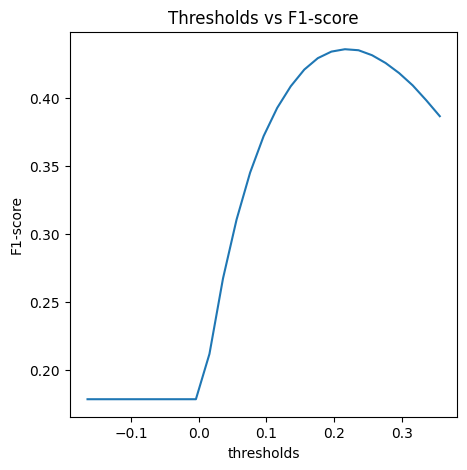

In [35]:
plt.figure(figsize=(5,5))
sns.lineplot(x=threshold_values , y=f1_scores)
plt.xlabel("thresholds")
plt.ylabel("F1-score")
plt.title("Thresholds vs F1-score")

plt.show()


In [36]:
print('Best threshold: ', threshold_values[np.argmax(f1_scores)])
print('Best F1-Score: ', np.max(f1_scores))


Best threshold:  0.21589096821794715
Best F1-Score:  0.43576234462310415


In [37]:
# Creating a light gradient boosting model.
from sklearn.metrics import f1_score, classification_report

# Initializing the model
lgbm = lgb.LGBMClassifier(
    objective='binary',
    num_leaves=74,  # En iyi parametre olarak belirlenen yaprak sayısı
    max_depth=7,    # En iyi parametre olarak belirlenen maksimum derinlik
    learning_rate=0.0820643967899203,  # En iyi parametre olarak belirlenen öğrenme oranı
    min_data_in_leaf=31,  # En iyi parametre olarak belirlenen her yaprakta olması gereken minimum veri sayısı
    bagging_fraction=0.9701151207124787,  # En iyi parametre olarak belirlenen bagging oranı
    bagging_freq=8,  # En iyi parametre olarak belirlenen bagging sıklığı
    feature_fraction=0.8385841711914909,  # En iyi parametre olarak belirlenen özellik oranı
    lambda_l1=0.5733670416719333,  # En iyi parametre olarak belirlenen L1 düzenlileştirme
    lambda_l2=0.12850035323391018,  # En iyi parametre olarak belirlenen L2 düzenlileştirme
    max_bin=242  # En iyi parametre olarak belirlenen maksimum bin sayısı
)

# Modeli eğitim verileriyle eğitme
lgbm.fit(X_train, y_train)

# prediction
# Taking the best threshold as 0.21 from above
y_pred_train = (lgbm.predict_proba(X_train)[:, 1] >= 0.215).astype('int') #setting a threshold.
y_pred_test = (lgbm.predict_proba(X_test)[:, 1] >= 0.215).astype('int') #setting a threshold.

# Evaluation
print('Train F1 Score: {}'.format(f1_score(y_pred_train, y_train)))
print('Validation F1 Score: {}'.format(f1_score(y_pred_test, y_test)))
print("-"*50)
print(classification_report(y_pred_test, y_test))


[LightGBM] [Warning] lambda_l1 is set=0.5733670416719333, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5733670416719333
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l2 is set=0.12850035323391018, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.12850035323391018
[LightGBM] [Warning] bagging_fraction is set=0.9701151207124787, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9701151207124787
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] feature_fraction is set=0.8385841711914909, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8385841711914909
[LightGBM] [Warning] lambda_l1 is set=0.5733670416719333, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5733670416719333
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will b

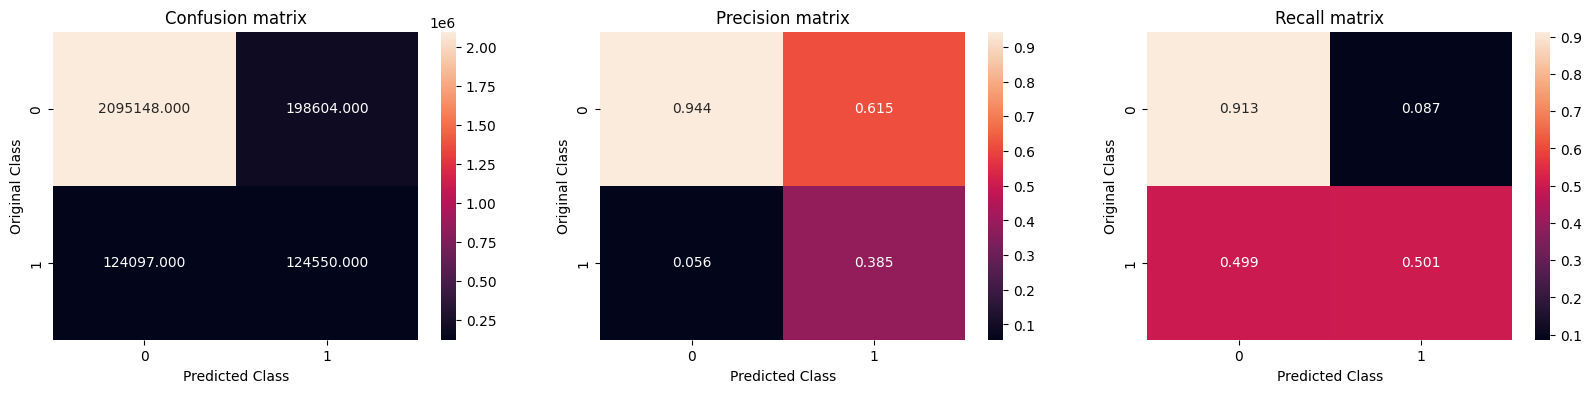

In [38]:
# Confusion, Precision and Recall matrix
plot_confusion_matrix(y_test,y_pred_test)


In [40]:
pickle.dump(lgbm, open("/Users/data/Desktop/Features@Library/lgbm_model_less.15:27", 'wb'))